# CEO-Request Challenge

## Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL per month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
 '2 stars': 50
 '3 stars': 40
 '4 stars': 0
 '5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below.

💪 But feel free to investigate other hypothesis instead with part 3.

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worst sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need.


⚠️ Don't start from scratch, update your existing package! 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [17]:
import numpy as np

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from olist.seller import Seller
seller = Seller().get_training_data()
seller.head

<bound method NDFrame.head of                              seller_id        seller_city seller_state  \
0     3442f8959a84dea7ee197c632cb2df15           campinas           SP   
1     d1b65fc7debc3361ea86b5f14c68d2e2         mogi guacu           SP   
2     ce3ad9de960102d0677a81f5d0bb7b2d     rio de janeiro           RJ   
3     c0f3eea2e14555b6faeea3dd58c1b1c3          sao paulo           SP   
4     51a04a8a6bdcb23deccc82b0b80742cf  braganca paulista           SP   
...                                ...                ...          ...   
2962  98dddbc4601dd4443ca174359b237166            sarandi           PR   
2963  f8201cab383e484733266d1906e2fdfa            palhoca           SC   
2964  74871d19219c7d518d0090283e03c137          sao paulo           SP   
2965  e603cf3fec55f8697c9059638d6c8eb5            pelotas           RS   
2966  9e25199f6ef7e7c347120ff175652c3b            taubate           SP   

      delay_to_carrier  wait_time     date_first_sale      date_last_sale  \
0   

In [ ]:
from olist.order import Order
seller_grs = Order().get_review_score()
seller_grs

In [ ]:
from olist.data import Olist
data = Olist().get_data()
orders_sellers = data['order_items'][['order_id', 'seller_id'
                                                   ]].drop_duplicates()
df = orders_sellers.merge(seller_grs, on='order_id')
df

In [ ]:
df['dim_is_two_star'] = 0  # Default value
df.loc[df['review_score'] == 2, 'dim_is_two_star'] = 1
df['dim_is_three_star'] = 0  # Default value
df.loc[df['review_score'] == 3, 'dim_is_three_star'] = 1
df

In [ ]:
df = df.groupby('seller_id').agg({'dim_is_two_star' : 'mean', 'dim_is_three_star' : 'mean'})
df

In [ ]:
seller = seller.merge(df, on='seller_id')
seller

In [ ]:
seller.rename(columns={'dim_is_three_star' : 'share_of_three_star', 'dim_is_two_star' : 'share_of_two_star'}, inplace=True)
review_score = seller['review_score']
seller = seller.drop('review_score', axis=1)
seller['review_score'] = review_score
seller

In [ ]:
seller['revenues'] = seller['sales']/10 + seller['months_on_olist']*80
seller

In [ ]:
seller['cost_of_reviews'] = seller['n_orders'] * (seller['share_of_one_stars'] * 100 + seller['share_of_two_star'] * 50 + seller['share_of_three_star'] * 40)
seller

In [ ]:
seller['profits'] = seller['revenues'] - seller['cost_of_reviews']
seller

In [ ]:
from olist.seller import Seller
Seller().get_training_data()

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate profits:
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative IT costs for each row using the function you defined before.
   - Calculate the cumulative net profit for each row.

4️⃣ Plot your results, and analyze them.

5️⃣ Determine the optimum number of sellers to keep, based on profits before and after IT costs. (Hint: look up `np.argmax`). What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

6️⃣ How important were the IT costs in your analysis?

In [133]:
import numpy as np

def IT_costs(n_sellers, n_items):
    a = 3157.27
    b = 978.23
    costs = a * np.sqrt(n_sellers) + b * np.sqrt(n_items)
    return costs

sellers_data = Seller().get_training_data()

sellers_data = sellers_data.sort_values(by='profits', ascending=False)
sellers_data = sellers_data.reset_index(drop=True)
sellers_data

sellers_data['cumulative_profits'] = 0
sellers_data['cumulative_IT_costs'] = 0
sellers_data['cumulative_net_profits'] = 0

sum1 = 0
sum2 = 0
sum3 = 0


for index, row in sellers_data.iterrows():
    sum1 += row['profits']
    sellers_data.loc[index, 'cumulative_profits'] = sum1
    
for index, row in sellers_data.iterrows():
    sum2 += row['quantity']
    sellers_data.loc[index, 'cumulative_IT_costs'] = IT_costs(index + 1, sum2)
    
sellers_data['cumulative_net_profits'] = sellers_data['cumulative_profits'] - sellers_data['cumulative_IT_costs']
    
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_five_stars,share_of_three_star,share_of_two_star,review_score,revenues,cost_of_reviews,profits,cumulative_profits,cumulative_IT_costs,cumulative_net_profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,0.561798,0.092697,0.025281,4.132022,23237.605,5199.044944,18038.560056,1.803856e+04,22964.917828,-4926.357772
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,0.629851,0.074627,0.017910,4.214925,19323.187,4714.029851,14609.157149,3.264772e+04,31254.985925,1392.731280
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,0.676420,0.041308,0.018933,4.339071,21004.203,6554.819277,14449.383723,4.709710e+04,41224.163282,5872.937646
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,0.692771,0.048193,0.012048,4.421687,8808.455,1520.000000,7288.455000,5.438556e+04,44339.889079,10045.666849
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,521,542,...,0.629126,0.058252,0.019417,4.194175,14571.119,7587.378641,6983.740359,6.136930e+04,51383.513743,9985.782544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,...,0.568690,0.075612,0.031949,4.074547,2553.569,15505.772098,-12952.203098,1.235753e+06,489511.812301,746241.520815
2963,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,...,0.527607,0.107800,0.040316,3.997371,4677.752,20308.606486,-15630.854486,1.220122e+06,491347.711731,728774.766900
2964,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,...,0.584483,0.093103,0.032759,4.077586,11948.842,28952.977011,-17004.135011,1.203118e+06,494024.237152,709094.106468
2965,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,...,0.482510,0.127707,0.047751,3.827873,21647.292,39509.383676,-17862.091676,1.185256e+06,496991.389117,688264.862827


In [142]:
sellers_data['Subscription_Fee'] = 80

In [140]:
# Determine the 10% highest review costs
review_cost_threshold = sellers_data['cost_of_reviews'].quantile(0.9)
lowest_10_percent = sellers_data[sellers_data['cost_of_reviews'] >= review_cost_threshold]
lowest_10_percent

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_five_stars,share_of_three_star,share_of_two_star,review_score,revenues,cost_of_reviews,profits,cumulative_profits,cumulative_IT_costs,cumulative_net_profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,0.561798,0.092697,0.025281,4.132022,23237.605,5199.044944,18038.560056,1.803856e+04,22964.917828,-4926.357772
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,0.629851,0.074627,0.017910,4.214925,19323.187,4714.029851,14609.157149,3.264772e+04,31254.985925,1392.731280
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,0.676420,0.041308,0.018933,4.339071,21004.203,6554.819277,14449.383723,4.709710e+04,41224.163282,5872.937646
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,0.692771,0.048193,0.012048,4.421687,8808.455,1520.000000,7288.455000,5.438556e+04,44339.889079,10045.666849
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,521,542,...,0.629126,0.058252,0.019417,4.194175,14571.119,7587.378641,6983.740359,6.136930e+04,51383.513743,9985.782544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,...,0.568690,0.075612,0.031949,4.074547,2553.569,15505.772098,-12952.203098,1.235753e+06,489511.812301,746241.520815
2963,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,...,0.527607,0.107800,0.040316,3.997371,4677.752,20308.606486,-15630.854486,1.220122e+06,491347.711731,728774.766900
2964,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,...,0.584483,0.093103,0.032759,4.077586,11948.842,28952.977011,-17004.135011,1.203118e+06,494024.237152,709094.106468
2965,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,...,0.482510,0.127707,0.047751,3.827873,21647.292,39509.383676,-17862.091676,1.185256e+06,496991.389117,688264.862827


In [143]:
# Apply a 10% penalty for these sellers
sellers_data['Adjusted_Subscription'] = sellers_data['Subscription_Fee']
sellers_data.loc[lowest_10_percent.index, 'Adjusted_Subscription'] *= 1.10

In [144]:
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_two_star,review_score,revenues,cost_of_reviews,profits,cumulative_profits,cumulative_IT_costs,cumulative_net_profits,Subscription_Fee,Adjusted_Subscription
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,0.025281,4.132022,23237.605,5199.044944,18038.560056,1.803856e+04,22964.917828,-4926.357772,80,88
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,0.017910,4.214925,19323.187,4714.029851,14609.157149,3.264772e+04,31254.985925,1392.731280,80,88
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,0.018933,4.339071,21004.203,6554.819277,14449.383723,4.709710e+04,41224.163282,5872.937646,80,88
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,0.012048,4.421687,8808.455,1520.000000,7288.455000,5.438556e+04,44339.889079,10045.666849,80,88
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,521,542,...,0.019417,4.194175,14571.119,7587.378641,6983.740359,6.136930e+04,51383.513743,9985.782544,80,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,...,0.031949,4.074547,2553.569,15505.772098,-12952.203098,1.235753e+06,489511.812301,746241.520815,80,88
2963,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,...,0.040316,3.997371,4677.752,20308.606486,-15630.854486,1.220122e+06,491347.711731,728774.766900,80,88
2964,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,...,0.032759,4.077586,11948.842,28952.977011,-17004.135011,1.203118e+06,494024.237152,709094.106468,80,88
2965,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,...,0.047751,3.827873,21647.292,39509.383676,-17862.091676,1.185256e+06,496991.389117,688264.862827,80,88


In [145]:
sellers_data['profits'] = sellers_data['profits'] + (sellers_data['Adjusted_Subscription'] - 80) * sellers_data['months_on_olist']

In [146]:
sellers_data['cumulative_profits'] = 0
sellers_data['cumulative_IT_costs'] = 0
sellers_data['cumulative_net_profits'] = 0

sum1 = 0
sum2 = 0
sum3 = 0


for index, row in sellers_data.iterrows():
    sum1 += row['profits']
    sellers_data.loc[index, 'cumulative_profits'] = sum1
    
for index, row in sellers_data.iterrows():
    sum2 += row['quantity']
    sellers_data.loc[index, 'cumulative_IT_costs'] = IT_costs(index + 1, sum2)
    
sellers_data['cumulative_net_profits'] = sellers_data['cumulative_profits'] - sellers_data['cumulative_IT_costs']
    
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_two_star,review_score,revenues,cost_of_reviews,profits,cumulative_profits,cumulative_IT_costs,cumulative_net_profits,Subscription_Fee,Adjusted_Subscription
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,0.025281,4.132022,23237.605,5199.044944,18134.560056,1.813456e+04,22964.917828,-4830.357772,80,88
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,0.017910,4.214925,19323.187,4714.029851,14777.157149,3.291172e+04,31254.985925,1656.731280,80,88
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,0.018933,4.339071,21004.203,6554.819277,14609.383723,4.752110e+04,41224.163282,6296.937646,80,88
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,0.012048,4.421687,8808.455,1520.000000,7376.455000,5.489756e+04,44339.889079,10557.666849,80,88
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,521,542,...,0.019417,4.194175,14571.119,7587.378641,7159.740359,6.205730e+04,51383.513743,10673.782544,80,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,...,0.031949,4.074547,2553.569,15505.772098,-12872.203098,1.269521e+06,489511.812301,780009.520815,80,88
2963,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,...,0.040316,3.997371,4677.752,20308.606486,-15534.854486,1.253986e+06,491347.711731,762638.766900,80,88
2964,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,...,0.032759,4.077586,11948.842,28952.977011,-16852.135011,1.237134e+06,494024.237152,743110.106468,80,88
2965,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,...,0.047751,3.827873,21647.292,39509.383676,-17702.091676,1.219432e+06,496991.389117,722440.862827,80,88


<AxesSubplot:ylabel='cumulative_profits'>

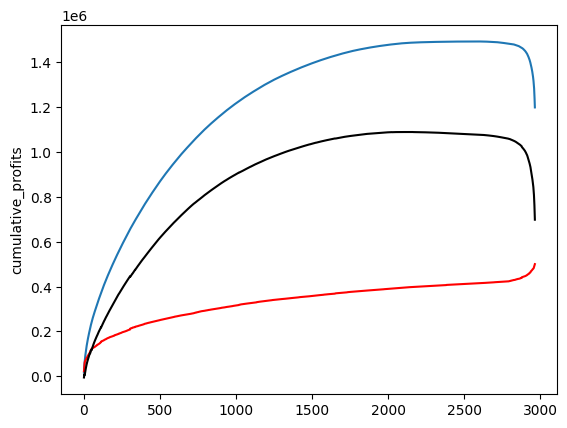

In [147]:
sns.lineplot(x=sellers_data.index, y=sellers_data['cumulative_profits'])
sns.lineplot(x=sellers_data.index, y=sellers_data['cumulative_IT_costs'], color='red')
sns.lineplot(x=sellers_data.index, y=sellers_data['cumulative_net_profits'], color='black')

In [ ]:
# Determine the 10% highest review costs
review_cost_threshold = sellers_data['review_cost'].quantile(0.9)

# Apply a 10% penalty for these sellers
sellers['Adjusted_Subscription'] = sellers['Subscription_Fee']
sellers.loc[lowest_10_percent.index, 'Adjusted_Subscription'] *= 1.10

# Total revenues and profits
sellers['Revenues'] = sellers['Sales_Fee'] + sellers['Subscription_Fee']
sellers['Adjusted_Revenues'] = sellers['Sales_Fee'] + sellers['Adjusted_Subscription']
sellers['Profit'] = sellers['Revenues'] - sellers['review_cost']
sellers['Adjusted_Profit'] = sellers['Adjusted_Revenues'] - sellers['review_cost']

<AxesSubplot:ylabel='cumulative_profits'>

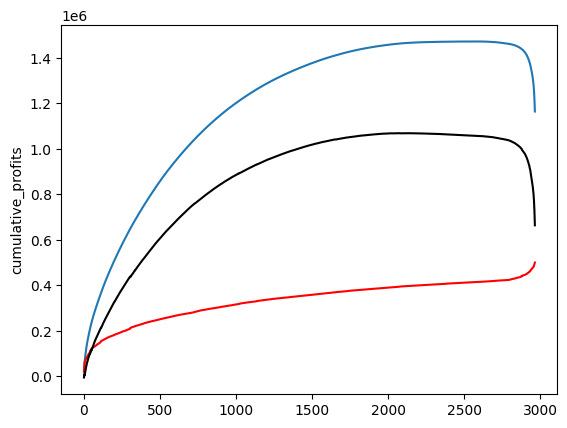

In [25]:
import seaborn as sns

sns.lineplot(x=sellers_data.index, y=sellers_data['cumulative_profits'])
sns.lineplot(x=sellers_data.index, y=sellers_data['cumulative_IT_costs'], color='red')
sns.lineplot(x=sellers_data.index, y=sellers_data['cumulative_net_profits'], color='black')

In [26]:
sellers_data['cumulative_net_profits'].max()

1068258.6839396146

In [27]:
sellers_data['cumulative_net_profits'].idxmax()

2077

In [31]:
import pandas as pd
pd.set_option('display.max_rows', None)

In [32]:
sellers_data[(sellers_data['cumulative_net_profits'] < 1050000) & (sellers_data.index > 2000)]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_five_stars,share_of_three_star,share_of_two_star,review_score,revenues,cost_of_reviews,profits,cumulative_profits,cumulative_IT_costs,cumulative_net_profits
2694,3d8fa2f5b647373c8620330c4e077a9f,sao paulo,SP,0.000000,9.322169,2018-04-30 14:32:34,2018-08-15 20:29:49,4.0,43,48,...,0.604651,0.069767,0.046512,4.093023,677.173,720.000000,-42.827000,1.468829e+06,418877.567117,1.049952e+06
2695,9599519be538b98748162a2b48248960,sao paulo,SP,0.000000,22.617454,2018-04-08 08:10:14,2018-04-08 08:10:14,0.0,1,3,...,0.000000,0.000000,0.000000,1.000000,57.000,100.000000,-43.000000,1.468786e+06,418913.602869,1.049873e+06
2696,2e2f44824ab87a0cb961f68bf4073e7f,curitiba,PR,0.974815,10.955590,2018-04-04 03:08:55,2018-04-04 03:08:55,0.0,1,1,...,0.000000,0.000000,1.000000,2.000000,4.800,50.000000,-45.200000,1.468741e+06,418945.879916,1.049795e+06
2697,d4828feed4cda2cd9d6b37899a95a71e,juzeiro do norte,CE,0.000000,13.507130,2018-08-07 00:45:12,2018-08-07 00:45:12,0.0,1,1,...,0.000000,0.000000,1.000000,2.000000,3.990,50.000000,-46.010000,1.468695e+06,418978.151313,1.049717e+06
2698,808d4348b916efa08e766ebad39f61eb,sao paulo,SP,0.000000,7.961433,2018-07-07 19:55:13,2018-08-22 10:55:23,1.0,21,21,...,0.714286,0.000000,0.000000,4.428571,153.110,200.000000,-46.890000,1.468648e+06,419047.943444,1.049600e+06
2699,8e6cc767478edae941d9bd9eb778d77a,araguari,MG,0.000000,16.496238,2017-01-29 19:31:49,2018-06-19 22:55:57,17.0,106,114,...,0.547170,0.103774,0.066038,3.943396,2043.058,2090.000000,-46.942000,1.468601e+06,419292.122109,1.049309e+06
2700,0336182e1b3e92f029d5354832045fdf,ibitinga,SP,4.852106,13.061111,2016-10-06 15:59:18,2016-10-06 15:59:18,0.0,1,2,...,0.000000,0.000000,1.000000,2.000000,2.980,50.000000,-47.020000,1.468554e+06,419326.249332,1.049228e+06
2701,bc8c8d665ec4664d286be0d521722b19,sao paulo,SP,3.865081,8.033924,2018-08-06 15:15:17,2018-08-06 15:15:17,0.0,1,1,...,0.000000,0.000000,1.000000,2.000000,2.250,50.000000,-47.750000,1.468507e+06,419358.496316,1.049148e+06
2702,7b7ed56ae755e2880f2b69632e839c1e,goiania,GO,0.000000,7.304653,2018-08-07 08:44:46,2018-08-15 19:45:16,0.0,5,5,...,0.600000,0.400000,0.000000,4.200000,32.150,80.000000,-47.850000,1.468459e+06,419398.235774,1.049060e+06
2703,344223b2a90784f64136a8a5da012e7f,gaspar,SC,0.000000,32.623993,2018-01-17 22:19:35,2018-01-17 22:19:35,0.0,1,1,...,0.000000,0.000000,1.000000,2.000000,1.090,50.000000,-48.910000,1.468410e+06,419430.471439,1.048979e+06


In [96]:
sellers_data['cumulative_net_profits'][2905] - sellers_data['cumulative_net_profits'][2966]

308179.4555665611

In [112]:
bad_sellers = list(sellers_data['seller_id'][2905 : ])
bad_sellers

['813348c996469b40f2e028d5429d3495',
 '4830e40640734fc1c52cd21127c341d4',
 '9b013e03b2ab786505a1d3b5c0756754',
 '9f505651f4a6abe901a56cdc21508025',
 'f262cbc1c910c83959f849465454ddd3',
 '7aa4334be125fcdd2ba64b3180029f14',
 '213b25e6f54661939f11710a6fddb871',
 'e26901d5ab434ce92fd9b5c256820a4e',
 '5656537e588803a555b8eb41f07a944b',
 'bbad7e518d7af88a0897397ffdca1979',
 '6973a06f484aacf400ece213dbf3d946',
 'f8db351d8c4c4c22c6835c19a46f01b0',
 'f46490624488d3ff7ce78613913a7711',
 'dc4a0fc896dc34b0d5bfec8438291c80',
 '4e922959ae960d389249c378d1c939f5',
 '36a968b544695394e4e9d7572688598f',
 '7d76b645482be4a332374e8223836592',
 '8160255418d5aaa7dbdc9f4c64ebda44',
 '54965bbe3e4f07ae045b90b0b8541f52',
 '1da3aeb70d7989d1e6d9b0e887f97c23',
 '562fc2f2c2863ab7e79a9e4388a58a14',
 '37515688008a7a40ac93e3b2e4ab203f',
 'f457c46070d02cadd8a68551231220dd',
 '972d0f9cf61b499a4812cf0bfa3ad3c4',
 '18a349e75d307f4b4cc646a691ed4216',
 '1025f0e2d44d7041d6cf58b6550e0bfa',
 '4c2b230173bb36f9b240f2b8ac11786e',
 

In [36]:
pd.reset_option('display.max_rows', None)

## Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after a honeymoon period of a few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


###   Investigate 1st approach

In [37]:
from olist.product import Product
product = Product().get_training_data()
product

product = product.drop('review_score', axis=1)

from olist.data import Olist
data = Olist().get_data()
order_items = data['order_items'].drop(['seller_id', 'order_item_id', 'shipping_limit_date', 'price', 'freight_value'], axis=1)
order_items

order_reviews = data['order_reviews'].drop(['review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'], axis=1)
order_reviews

tmp = order_items.merge(order_reviews, on='order_id')
tmp

product3 = product.merge(tmp, on='product_id')
product3

product3['dim_is_five_star'] = 0  # Default value
product3.loc[product3['review_score'] == 5, 'dim_is_five_star'] = 1
product3['dim_is_one_star'] = 0  # Default value
product3.loc[product3['review_score'] == 1, 'dim_is_one_star'] = 1
product3['dim_is_two_star'] = 0  # Default value
product3.loc[product3['review_score'] == 2, 'dim_is_two_star'] = 1
product3['dim_is_three_star'] = 0  # Default value
product3.loc[product3['review_score'] == 3, 'dim_is_three_star'] = 1

product3 = product3.groupby('product_id').agg({'category' : 'first', 'price' : 'first', 'review_score' : 'first', 'quantity' : 'first', 'sales' : 'first', 'order_id' : 'count', 'dim_is_one_star' : 'mean', 'dim_is_two_star' : 'mean', 'dim_is_three_star' : 'mean', 'dim_is_five_star' : 'mean'}).reset_index()
product3.rename(columns={'order_id' : 'n_orders'}, inplace=True)
product3

product3.rename(columns={'dim_is_one_star' : 'share_of_one_stars', 'dim_is_two_star' : 'share_of_two_stars', 'dim_is_three_star' : 'share_of_three_stars', 'dim_is_five_star' : 'share_of_five_stars'}, inplace=True)
product3

product3['review_cost'] = product3['n_orders'] * (100 * product3['share_of_one_stars'] + 50 * product3['share_of_two_stars'] + 40 * product3['share_of_three_stars'])
product3

product3['profit'] = product3['sales']/10 - product3['review_cost']
product3

product3 = product3.sort_values(by='profit', ascending=False)
product3 = product3.reset_index(drop=True)
product3

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.000000,10.910000,0.000000,1.000000,5.000000,1,1,10.91
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,10.300000,16.900000,0.000000,0.500000,3.500000,2,2,33.80
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.944444,325.627273,0.200000,0.400000,3.700000,10,11,3581.90
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.200000,399.900000,0.000000,0.000000,2.000000,1,1,399.90
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,9.000000,137.900000,0.000000,1.000000,5.000000,1,1,137.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,13b25797ad1e6d6c7cd3cbeb35f8ee7a,44.0,348.0,1.0,18250.0,25.0,25.0,25.0,furniture_mattress_and_upholstery,8.700000,129.900000,0.000000,0.000000,3.000000,1,1,129.90
31480,dc36a7859b743d8610a2bbbaea26ece9,29.0,2073.0,2.0,2500.0,41.0,21.0,21.0,furniture_mattress_and_upholstery,6.100000,249.000000,0.000000,1.000000,5.000000,1,1,249.00
31481,107fde0930956120d1e13dd1062fbb46,51.0,418.0,1.0,30000.0,60.0,73.0,60.0,furniture_mattress_and_upholstery,17.500000,399.990000,0.000000,0.000000,4.000000,1,1,399.99
31482,726b4e18f00255e2e63491bcba3f60b8,41.0,866.0,1.0,1700.0,70.0,10.0,100.0,furniture_mattress_and_upholstery,12.409091,84.545455,0.136364,0.681818,4.272727,22,22,1860.00


In [49]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='profit', ylabel='Count'>

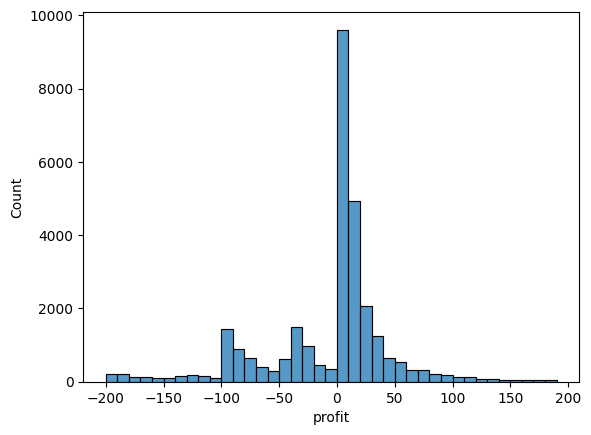

In [50]:
bins = np.arange(-200, 200, 10)
sns.histplot(data=product3, x='profit', bins=bins)

/home/raphaelsisso/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


<AxesSubplot:xlabel='profit', ylabel='Count'>

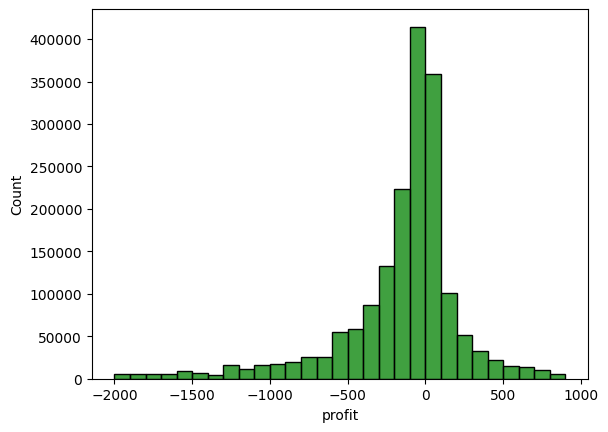

In [51]:
bins = np.arange(-2000, 1000, 100)
sns.histplot(data=product3, x='profit', weights=np.abs(product3['profit']), bins=bins, color='green')

In [86]:
product3['cumulative_profits'] = 0
product3['cumulative_sales'] = 0


sum1 = 0
sum2 = 0

for index, row in product3.iterrows():
    sum1 += row['profit']
    product3.loc[index, 'cumulative_profits'] = sum1
    
for index, row in product3.iterrows():
    sum2 += row['sales']
    product3.loc[index, 'cumulative_sales'] = sum2
    
product3

,product_id,category,price,review_score,quantity,sales,n_orders,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_cost,profit,cumulative_profits,cumulative_sales
0,d6160fb7873f184099d9bc95e30376af,computers,1397.124000,1,35,48899.34,35,0.057143,0.028571,0.000000,0.800000,250.0,4639.934,4639.934,4.889934e+04
1,bb50f2e236e5eea0100680137654686c,health_beauty,327.615385,1,195,63885.00,196,0.076531,0.020408,0.086735,0.581633,2380.0,4008.500,8648.434,1.127843e+05
2,6cdd53843498f92890544667809f1595,health_beauty,350.834615,5,156,54730.20,155,0.077419,0.032258,0.051613,0.664516,1770.0,3703.020,12351.454,1.675145e+05
3,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,598.950794,5,63,37733.90,63,0.031746,0.015873,0.031746,0.714286,330.0,3443.390,15794.844,2.052484e+05
4,588531f8ec37e7d5ff5b7b22ea0488f8,computers,1414.599500,5,20,28291.99,19,0.052632,0.000000,0.210526,0.631579,260.0,2569.199,18364.043,2.335404e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,71.364137,4,527,37608.90,524,0.095420,0.045802,0.120229,0.517176,8720.0,-4959.110,-541411.613,1.310078e+07
31480,99a4788cb24856965c36a24e339b6058,bed_bath_table,88.167131,5,488,43025.56,482,0.126556,0.039419,0.136929,0.493776,9690.0,-5387.444,-546799.057,1.314381e+07
31481,368c6c730842d78016ad823897a372db,garden_tools,54.270103,5,388,21056.80,388,0.167526,0.025773,0.072165,0.548969,8120.0,-6014.320,-552813.377,1.316487e+07
31482,53759a2ecddad2bb87a079a1f1519f73,garden_tools,54.657373,5,373,20387.20,373,0.174263,0.032172,0.099196,0.554960,8580.0,-6541.280,-559354.657,1.318525e+07


<AxesSubplot:ylabel='cumulative_profits'>

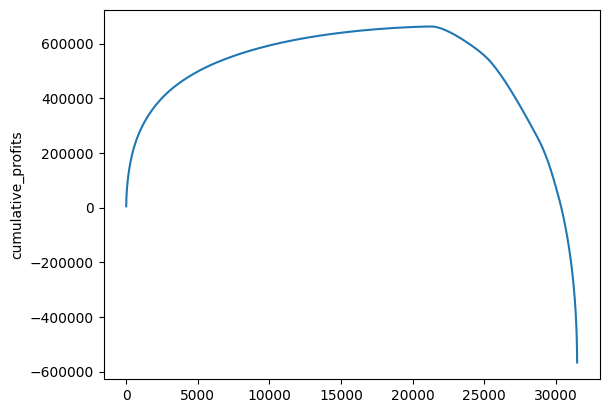

In [125]:
sns.lineplot(x=product3.index, y=product3['cumulative_profits'])


<AxesSubplot:ylabel='cumulative_sales'>

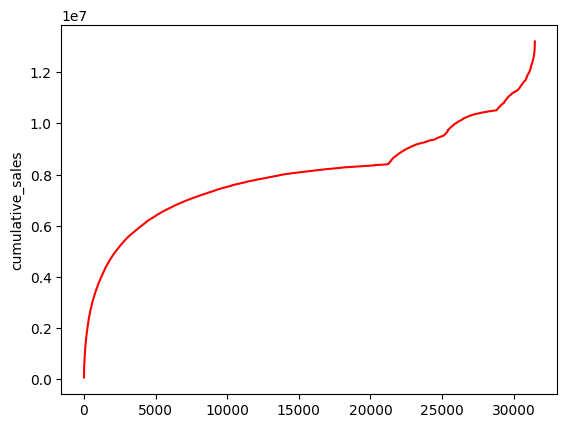

In [126]:
sns.lineplot(x=product3.index, y='cumulative_sales', data=product3, color='red')

In [58]:
product3['cumulative_profits'].max()

662501.5119999421

In [59]:
product3['cumulative_profits'].idxmax()

21247

In [29]:
product3[product3['profit'] < -1000]['profit'].sum()

-168030.74199999997

In [30]:
product3[(product3['profit'] > -1000) & (product3['profit'] < 0)]['profit'].sum()

-1060027.705

In [31]:
product3[product3['profit'] > 0]['profit'].sum()

662501.5120000001

In [90]:
product3['profits_per_order'] = product3['profit']/product3['n_orders']
product3['sales_per_order'] = product3['sales']/product3['n_orders']


In [91]:
product3['cumulative_profits_per_order'] = 0
product3['cumulative_sales_per_order'] = 0

sum1 = 0
sum2 = 0

for index, row in product3.iterrows():
    sum1 += row['profits_per_order']
    product3.loc[index, 'cumulative_profits_per_order'] = sum1
    
for index, row in product3.iterrows():
    sum2 += row['sales_per_order']
    product3.loc[index, 'cumulative_sales_per_order'] = sum2
    
product3

,product_id,category,price,review_score,quantity,sales,n_orders,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_cost,profit,cumulative_profits,cumulative_sales,profits_per_order,sales_per_order,cumulative_profits_per_order,cumulative_sales_per_order
0,d6160fb7873f184099d9bc95e30376af,computers,1397.124000,1,35,48899.34,35,0.057143,0.028571,0.000000,0.800000,250.0,4639.934,4639.934,4.889934e+04,132.569543,1397.124000,132.569543,1.397124e+03
1,bb50f2e236e5eea0100680137654686c,health_beauty,327.615385,1,195,63885.00,196,0.076531,0.020408,0.086735,0.581633,2380.0,4008.500,8648.434,1.127843e+05,20.451531,325.943878,153.021073,1.723068e+03
2,6cdd53843498f92890544667809f1595,health_beauty,350.834615,5,156,54730.20,155,0.077419,0.032258,0.051613,0.664516,1770.0,3703.020,12351.454,1.675145e+05,23.890452,353.098065,176.911525,2.076166e+03
3,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,598.950794,5,63,37733.90,63,0.031746,0.015873,0.031746,0.714286,330.0,3443.390,15794.844,2.052484e+05,54.656984,598.950794,231.568509,2.675117e+03
4,588531f8ec37e7d5ff5b7b22ea0488f8,computers,1414.599500,5,20,28291.99,19,0.052632,0.000000,0.210526,0.631579,260.0,2569.199,18364.043,2.335404e+05,135.221000,1489.052105,366.789509,4.164169e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,71.364137,4,527,37608.90,524,0.095420,0.045802,0.120229,0.517176,8720.0,-4959.110,-541411.613,1.310078e+07,-9.463950,71.772710,-52127.976631,4.570624e+06
31480,99a4788cb24856965c36a24e339b6058,bed_bath_table,88.167131,5,488,43025.56,482,0.126556,0.039419,0.136929,0.493776,9690.0,-5387.444,-546799.057,1.314381e+07,-11.177270,89.264647,-52139.153900,4.570713e+06
31481,368c6c730842d78016ad823897a372db,garden_tools,54.270103,5,388,21056.80,388,0.167526,0.025773,0.072165,0.548969,8120.0,-6014.320,-552813.377,1.316487e+07,-15.500825,54.270103,-52154.654725,4.570767e+06
31482,53759a2ecddad2bb87a079a1f1519f73,garden_tools,54.657373,5,373,20387.20,373,0.174263,0.032172,0.099196,0.554960,8580.0,-6541.280,-559354.657,1.318525e+07,-17.536944,54.657373,-52172.191669,4.570822e+06


In [92]:
product4 = product3.sort_values(by='cumulative_profits_per_order', ascending=False)
product4 = product4.reset_index(drop=True)
product4

,product_id,category,price,review_score,quantity,sales,n_orders,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_cost,profit,cumulative_profits,cumulative_sales,profits_per_order,sales_per_order,cumulative_profits_per_order,cumulative_sales_per_order
0,88b3956a8179086a0c985a39644ec47d,sports_leisure,1001.000000,1,1,1001.00,1,1.000000,0.000000,0.000000,0.000000,100.0,0.100,662501.512,8.412515e+06,0.100000,1001.000000,330231.617245,3.583598e+06
1,8435e69e8ca35cc17d3471e240ea0d44,baby,250.000000,5,2,500.00,2,0.000000,0.500000,0.000000,0.500000,50.0,0.000,662501.512,8.413015e+06,0.000000,250.000000,330231.617245,3.583848e+06
2,8bb27b1d96be90b36b8d0c7f30931d52,housewares,285.714286,5,7,2000.00,7,0.000000,0.571429,0.000000,0.428571,200.0,0.000,662501.512,8.415015e+06,0.000000,285.714286,330231.617245,3.584133e+06
3,24bf010d82955430eeea5ed7643711c7,sports_leisure,999.990000,1,1,999.99,1,1.000000,0.000000,0.000000,0.000000,100.0,-0.001,662501.511,8.416015e+06,-0.001000,999.990000,330231.616245,3.585133e+06
4,3344f3ccc35b04b81d8cc2aefabcbcdd,baby,499.990000,5,2,999.98,2,0.500000,0.000000,0.000000,0.500000,100.0,-0.002,662501.509,8.417015e+06,-0.001000,499.990000,330231.615245,3.585633e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,aca2eb7d00ea1a7b8ebd4e68314663af,furniture_decor,71.364137,4,527,37608.90,524,0.095420,0.045802,0.120229,0.517176,8720.0,-4959.110,-541411.613,1.310078e+07,-9.463950,71.772710,-52127.976631,4.570624e+06
31480,99a4788cb24856965c36a24e339b6058,bed_bath_table,88.167131,5,488,43025.56,482,0.126556,0.039419,0.136929,0.493776,9690.0,-5387.444,-546799.057,1.314381e+07,-11.177270,89.264647,-52139.153900,4.570713e+06
31481,368c6c730842d78016ad823897a372db,garden_tools,54.270103,5,388,21056.80,388,0.167526,0.025773,0.072165,0.548969,8120.0,-6014.320,-552813.377,1.316487e+07,-15.500825,54.270103,-52154.654725,4.570767e+06
31482,53759a2ecddad2bb87a079a1f1519f73,garden_tools,54.657373,5,373,20387.20,373,0.174263,0.032172,0.099196,0.554960,8580.0,-6541.280,-559354.657,1.318525e+07,-17.536944,54.657373,-52172.191669,4.570822e+06


<AxesSubplot:ylabel='cumulative_profits_per_order'>

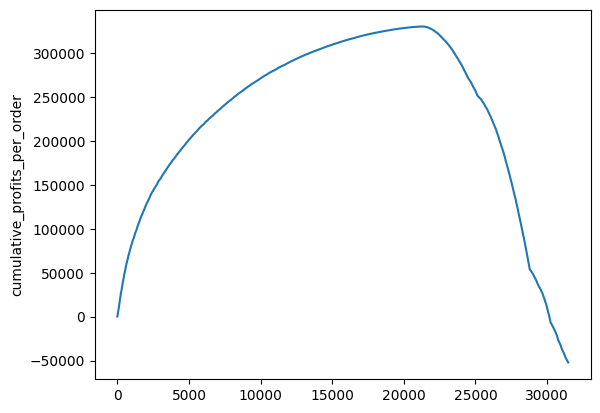

In [93]:
sns.lineplot(x=product3.index, y=product3['cumulative_profits_per_order'])

<AxesSubplot:ylabel='cumulative_sales_per_order'>

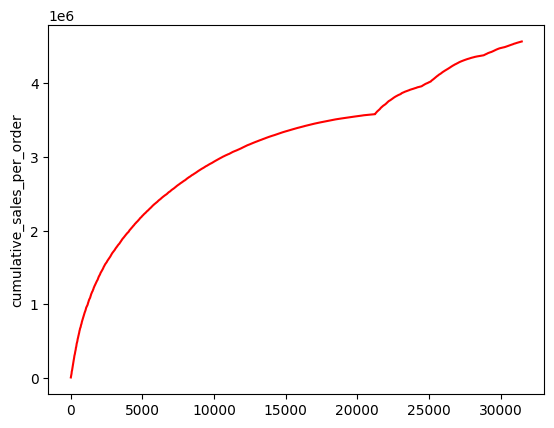

In [94]:
sns.lineplot(x=product3.index, y='cumulative_sales_per_order', data=product3, color='red')

In [98]:
product_cat = product3.groupby('category').agg({'price' : 'mean', 'review_score' : 'mean', 'quantity' : 'sum', 'sales' : 'sum', 'n_orders' : 'sum', 'review_cost' : 'sum', 'profit' : 'sum'})
product_cat

,price,review_score,quantity,sales,n_orders,review_cost,profit
category,,,,,,,
agro_industry_and_commerce,441.921263,3.887324,209,71443.60,209,3270.0,3874.360
air_conditioning,208.906065,3.975000,291,54285.16,287,5260.0,168.516
art,207.937102,4.392157,199,23859.94,198,3370.0,-984.006
arts_and_craftmanship,65.839474,4.421053,24,1814.01,24,420.0,-238.599
audio,116.488832,3.741379,364,50688.50,361,8350.0,-3281.150
...,...,...,...,...,...,...,...
stationery,101.140229,4.328916,2498,226957.76,2491,33600.0,-10904.224
tablets_printing_image,72.895986,4.000000,82,6638.42,81,1040.0,-376.158
telephony,82.415361,3.942029,4514,318839.15,4495,83850.0,-51966.085


In [99]:
product_cat = product_cat.sort_values(by='profit', ascending=False)
product_cat

,price,review_score,quantity,sales,n_orders,review_cost,profit
category,,,,,,,
computers,1183.207284,3.551724,202,216234.13,200,2940.0,18683.413
watches_gifts,332.773994,4.232019,5953,1187783.57,5922,104840.0,13938.357
musical_instruments,325.756045,4.137184,661,184533.73,658,8760.0,9693.373
small_appliances,348.810033,4.236364,668,186666.82,667,9460.0,9206.682
cool_stuff,210.455991,4.211009,3764,619225.27,3747,53870.0,8052.527
...,...,...,...,...,...,...,...
housewares,98.015299,4.132308,6875,623828.14,6863,113620.0,-51237.186
telephony,82.415361,3.942029,4514,318839.15,4495,83850.0,-51966.085
computers_accessories,154.209262,4.003129,7766,899465.74,7790,152490.0,-62543.426


<AxesSubplot:xlabel='profit', ylabel='Count'>

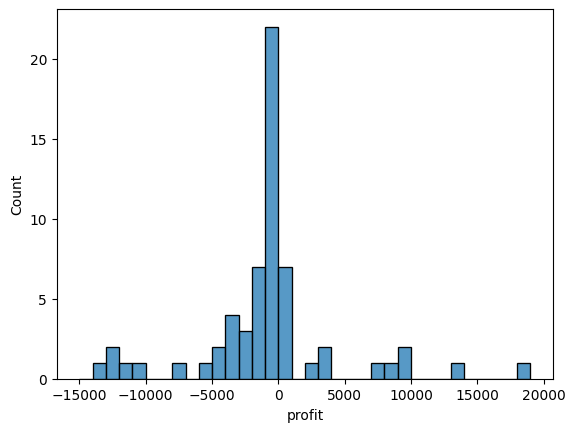

In [100]:
bins = np.arange(-15000, 20000, 1000)
sns.histplot(data=product_cat, x='profit', bins=bins)

/home/raphaelsisso/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


<AxesSubplot:xlabel='profit', ylabel='Count'>

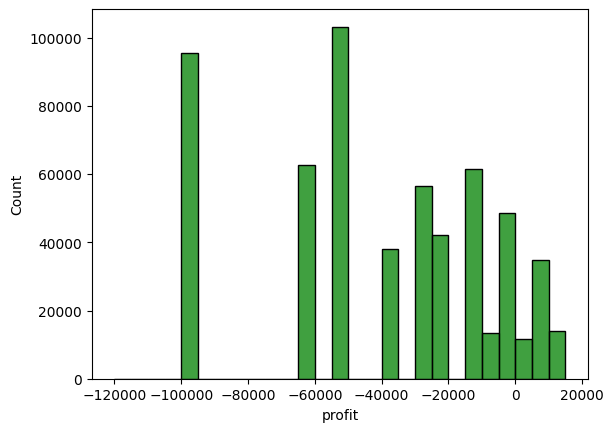

In [104]:
bins = np.arange(-120000, 20000, 5000)
sns.histplot(data=product_cat, x='profit', weights=np.abs(product_cat['profit']), bins=bins, color='green')

In [ ]:
product3[(product3['profit'] > -1000) & (product3['profit'] < 0)]['profit'].sum()

## Analyzing the products without bad sellers

In [106]:
order_items_2 = data['order_items'].drop(['order_item_id', 'shipping_limit_date', 'price', 'freight_value'], axis=1)
order_items_2

,order_id,product_id,seller_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87
...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79


In [114]:
order_items_2 = order_items_2[~order_items_2['seller_id'].isin(bad_sellers)]
order_items_2

,order_id,product_id,seller_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87
...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79


In [115]:
tmp2 = order_items_2.merge(order_reviews, on='order_id')


product_gs = product.merge(tmp2, on='product_id')

product_gs['dim_is_five_star'] = 0  # Default value
product_gs.loc[product_gs['review_score'] == 5, 'dim_is_five_star'] = 1
product_gs['dim_is_one_star'] = 0  # Default value
product_gs.loc[product_gs['review_score'] == 1, 'dim_is_one_star'] = 1
product_gs['dim_is_two_star'] = 0  # Default value
product_gs.loc[product_gs['review_score'] == 2, 'dim_is_two_star'] = 1
product_gs['dim_is_three_star'] = 0  # Default value
product_gs.loc[product_gs['review_score'] == 3, 'dim_is_three_star'] = 1

product_gs = product_gs.groupby('product_id').agg({'category' : 'first', 'price' : 'first', 'review_score' : 'first', 'quantity' : 'first', 'sales' : 'first', 'order_id' : 'count', 'dim_is_one_star' : 'mean', 'dim_is_two_star' : 'mean', 'dim_is_three_star' : 'mean', 'dim_is_five_star' : 'mean'}).reset_index()
product_gs.rename(columns={'order_id' : 'n_orders'}, inplace=True)

product_gs.rename(columns={'dim_is_one_star' : 'share_of_one_stars', 'dim_is_two_star' : 'share_of_two_stars', 'dim_is_three_star' : 'share_of_three_stars', 'dim_is_five_star' : 'share_of_five_stars'}, inplace=True)

product_gs['review_cost'] = product_gs['n_orders'] * (100 * product_gs['share_of_one_stars'] + 50 * product_gs['share_of_two_stars'] + 40 * product_gs['share_of_three_stars'])

product_gs['profit'] = product_gs['sales']/10 - product_gs['review_cost']

product_gs = product_gs.sort_values(by='profit', ascending=False)
product_gs = product_gs.reset_index(drop=True)

In [118]:
product_gs['cumulative_profits'] = 0
product_gs['cumulative_sales'] = 0


sum1 = 0
sum2 = 0

for index, row in product_gs.iterrows():
    sum1 += row['profit']
    product_gs.loc[index, 'cumulative_profits'] = sum1
    
for index, row in product_gs.iterrows():
    sum2 += row['sales']
    product_gs.loc[index, 'cumulative_sales'] = sum2
    
product_gs

,product_id,category,price,review_score,quantity,sales,n_orders,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_cost,profit,cumulative_profits,cumulative_sales
0,d6160fb7873f184099d9bc95e30376af,computers,1397.124000,1.0,35.0,48899.34,35.0,0.057143,0.028571,0.000000,0.800000,250.0,4639.934,4639.934,48899.34
1,99a4788cb24856965c36a24e339b6058,bed_bath_table,88.167131,5.0,488.0,43025.56,6.0,0.000000,0.000000,0.166667,0.833333,40.0,4262.556,8902.490,91924.90
2,bb50f2e236e5eea0100680137654686c,health_beauty,327.615385,1.0,195.0,63885.00,196.0,0.076531,0.020408,0.086735,0.581633,2380.0,4008.500,12910.990,155809.90
3,6cdd53843498f92890544667809f1595,health_beauty,350.834615,5.0,156.0,54730.20,155.0,0.077419,0.032258,0.051613,0.664516,1770.0,3703.020,16614.010,210540.10
4,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,598.950794,5.0,63.0,37733.90,63.0,0.031746,0.015873,0.031746,0.714286,330.0,3443.390,20057.400,248274.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
product_gs = product_gs[product_gs['product_id'].notna()]
product_gs

,product_id,category,price,review_score,quantity,sales,n_orders,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_cost,profit,cumulative_profits,cumulative_sales
0,d6160fb7873f184099d9bc95e30376af,computers,1397.124000,1.0,35.0,48899.34,35.0,0.057143,0.028571,0.000000,0.800000,250.0,4639.934,4639.934,4.889934e+04
1,99a4788cb24856965c36a24e339b6058,bed_bath_table,88.167131,5.0,488.0,43025.56,6.0,0.000000,0.000000,0.166667,0.833333,40.0,4262.556,8902.490,9.192490e+04
2,bb50f2e236e5eea0100680137654686c,health_beauty,327.615385,1.0,195.0,63885.00,196.0,0.076531,0.020408,0.086735,0.581633,2380.0,4008.500,12910.990,1.558099e+05
3,6cdd53843498f92890544667809f1595,health_beauty,350.834615,5.0,156.0,54730.20,155.0,0.077419,0.032258,0.051613,0.664516,1770.0,3703.020,16614.010,2.105401e+05
4,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,598.950794,5.0,63.0,37733.90,63.0,0.031746,0.015873,0.031746,0.714286,330.0,3443.390,20057.400,2.482740e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26100,43423cdffde7fda63d0414ed38c11a73,watches_gifts,62.153548,4.0,93.0,5780.28,92.0,0.152174,0.076087,0.184783,0.413043,2430.0,-1851.972,-83804.024,1.129216e+07
26101,0a57f7d2c983bcf8188589a5fea4a8da,watches_gifts,114.492308,1.0,104.0,11907.20,102.0,0.254902,0.049020,0.058824,0.509804,3090.0,-1899.280,-85703.304,1.130407e+07
26102,ee3d532c8a438679776d222e997606b3,computers_accessories,99.993750,1.0,32.0,3199.80,23.0,1.000000,0.000000,0.000000,0.000000,2300.0,-1980.020,-87683.324,1.130727e+07
26103,cd46a885543f0e169a49f1eb25c04e43,computers_accessories,99.990000,5.0,30.0,2999.70,30.0,0.733333,0.033333,0.033333,0.133333,2290.0,-1990.030,-89673.354,1.131027e+07


<AxesSubplot:ylabel='cumulative_profits'>

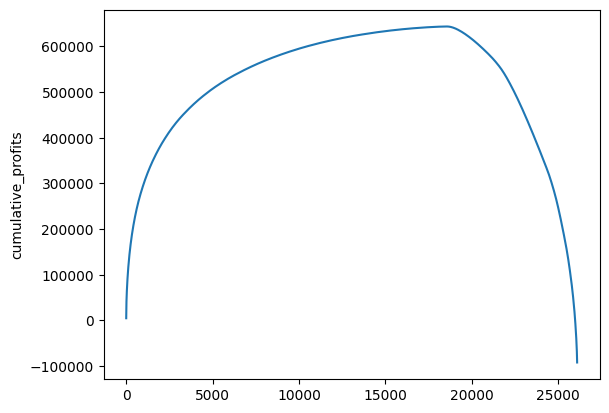

In [128]:
sns.lineplot(x=product_gs.index, y=product_gs['cumulative_profits'])


In [ ]:
product_gs

In [129]:
product3['cumulative_profits'].max()

662501.5119999421

In [130]:
product_gs['cumulative_profits'].max()

643682.4469999524

In [131]:
product_gs['cumulative_profits'].idxmax()

18529

## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪